# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
# import quadrotor

# print("Mass    =", quadrotor.MASS)
# print("Length  =", quadrotor.LENGTH)
# print("Inertia =", quadrotor.INERTIA)
# print("Dt      =", quadrotor.DT)
# print("state size   =", quadrotor.DIM_STATE)
# print("control size =", quadrotor.DIM_CONTROL)



## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [2]:
import quadrotor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
# %matplotlib inline
# %matplotlib widget
import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
from typing import Tuple, Any
from qpsolvers import Problem, solve_problem
import gc
import qpsolvers
def controller(x,t):
    return np.zeros(2)

# x_init = np.array([0., 0., 0., 0., 0., 0.])
# horizon_length = 10
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)



## Part 1
1. Given State dynamics:
$$\begin{align} 
\dot{p_x} &= v_x\\
\dot{v}_x &= - \frac{(u_1 + u_2) \sin \theta}{m} \\ 
\dot{p_y} &= v_y\\
\dot{v}_y &= \frac{(u_1 + u_2) \cos \theta}{m}  - g\\
\dot{\theta} &= \omega\\
\dot{\omega} &= \frac{r (u_1 - u_2)}{I} \end{align}$$

After Discretizing the state dynamics and doing Taylor Series Expansion to get a linear approximation
$$\begin{align}
    \delta p_{x_{n+1}} &= \delta p_{x_n} + \delta t \delta v_{x_n} \\
    \delta v_{x_{n+1}} &= \delta v_{x_n} - \delta t \delta \theta_n \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - \delta t (\delta u_{1_n} +  \delta u_{2_n} )\frac{\sin \theta_n}{m}\\
    \delta p_{y_{n+1}} &= \delta p_{y_n} + \delta t \delta v_{y_n} \\
    \delta v_{y_{n+1}} &= \delta v_{y_n} - \delta t \delta \theta_n \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} + \delta t (\delta u_{1_n} + \delta u_{2_n}) \frac{\cos \theta_n}{m}\\
    \delta \theta_{n+1} &= \delta \theta_{n} + \delta t \delta \omega_n \\
    \delta \omega_{n+1} &= \delta \omega_{n} + \delta t \frac{L(\delta u_{1_n} - \delta u_{2_n})}{I}
\end{align}$$

In [3]:
class Optimization:
    def __init__(self, m, l, I, dt, g, xdim, udim):
        self.m = m
        self.l = l
        self.I = I
        self.dt = dt
        self.g = g
        self.xdim = xdim
        self.udim = udim

    def quadrotor_dynamics(self, x_init, y, N=100):
        nvar = self.xdim + self.udim
        # Print the shapes
        # print(f"Total shape of y: {y.shape}")
        # print(f"Total shape of x_init: {x_init.shape}")
        y = np.asarray(y).flatten()
        x_init = np.asarray(x_init).flatten()

        # Define the placeholders for A and b
        A = np.zeros((6 * N, nvar * N))
        b = np.zeros(6 * N)

        # Define the initial state constraints
        A[:6, :] = np.eye(6, nvar * N)
        b[:6] = x_init - y[:6]

        # Define the constraints for the rest of the time steps
        for t in range(N-1):
            # Propogate the indices
            i = t * nvar
            n = i
            n1 = i + nvar

            # Assign the variables at time step t
            px = y[n]
            vx = y[n + 1]
            py = y[n + 2]
            vy = y[n + 3]
            theta = y[n + 4]
            omega = y[n + 5]
            u1 = y[n + 6]
            u2 = y[n + 7]

            # Assign the variables at time step t+1
            px_1 = y[n1]
            vx_1 = y[n1 + 1]
            py_1 = y[n1 + 2]
            vy_1 = y[n1 + 3]
            theta_1 = y[n1 + 4]
            omega_1 = y[n1 + 5]

            # Position x constraint
            A[6 * (t+1), n] = 1
            A[6 * (t+1), n + 1] = self.dt
            A[6 * (t+1), n1] = -1
            b[6 * (t+1)] = px + (self.dt * vx) - px_1

            # Velocity x constraint
            A[6 * (t+1) + 1, n + 1] = 1
            A[6 * (t+1) + 1, n + 4] = -self.dt * ((u1 + u2) * np.cos(theta) / self.m)
            A[6 * (t+1) + 1, n + 6] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n + 7] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n1 + 1] = -1
            b[6 * (t+1) + 1] = vx - (self.dt * (u1 + u2) * np.sin(theta) / self.m) - vx_1

            # Position y constraint
            A[6 * (t+1) + 2, n + 2] = 1
            A[6 * (t+1) + 2, n + 3] = self.dt
            A[6 * (t+1) + 2, n1 + 2] = -1
            b[6 * (t+1) + 2] = py + self.dt * vy - py_1
            
            # Velocity y constraint
            A[6 * (t+1) + 3, n + 3] = 1
            A[6 * (t+1) + 3, n + 4] = -self.dt * ((u1 + u2) * np.sin(theta) / self.m)
            A[6 * (t+1) + 3, n + 6] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n + 7] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n1 + 3] = -1
            b[6 * (t+1) + 3] = vy + self.dt * (((u1 + u2) * np.cos(theta) / self.m) - 9.81) - vy_1

            # Angle theta constraint
            A[6 * (t+1) + 4, n + 4] = 1
            A[6 * (t+1) + 4, n + 5] = self.dt
            A[6 * (t+1) + 4, n1 + 4] = -1
            b[6 * (t+1) + 4] = theta + self.dt * omega - theta_1

            # Angular velocity omega constraint
            A[6 * (t+1) + 5, n + 5] = 1
            A[6 * (t+1) + 5, n + 6] = self.dt * self.l / self.I
            A[6 * (t+1) + 5, n + 7] = -self.dt * self.l / self.I
            A[6 * (t+1) + 5, n1 + 5] = -1
            b[6 * (t+1) + 5] = omega + self.dt * self.l * (u1 - u2) / self.I - omega_1

        # # Print shapes of A and b
        # print(f"Shape of A: {A.shape}")
        # print(f"Shape of b: {b.shape}")
        return A, b
    
    def traj_gen(self, k: int, N: int = 100, MAX_Y: int = 3, MAX_X: int = 1) -> Tuple[float, float, float]:
        # Validate that the wavelength N is a multiple of 100
        if N % 100 != 0:
            raise ValueError(
                f'For the Wavelength N = {N}, IT IS NOT A MULTIPLE OF 100.')

        # Initialize position and orientation
        x_k: float = 0.0
        y_k: float = 0.0
        # Orientation cycles every 100 steps
        theta_k: float = (k / 100) * (2 * np.pi)

        # Map k to its position within the current wavelength cycle
        k = k % N
        y_k = (1.0 + np.sin(-np.pi/2 + (2 * np.pi * k) / N))*3
        x_k = (np.cos(-np.pi/2 + (2 * np.pi * k) / N))

        # # Determine the position (x_k, y_k) based on the current segment
        # if k < (N / 5):  # Segment 1: Start position
        #     x_k = 0.0
        #     # y_k = 0.0
        # elif (N / 5) <= k < (2 * N / 5):  # Segment 2: Ascent to top-right corner
        #     x_k = float(MAX_X)
        #     # y_k = float(MAX_X)
        # elif (2 * N / 5) <= k < (3 * N / 5):  # Segment 3: Top of the loop
        #     x_k = 0.0
        #     # y_k = float(MAX_Y)
        # elif (3 * N / 5) <= k < (4 * N / 5):  # Segment 4: Descent to top-left corner
        #     x_k = -float(MAX_X)
        #     # y_k = float(MAX_X)
        # elif (4 * N / 5) <= k <= N:  # Segment 5: Return to start
        #     x_k = 0.0
        #     # y_k = 0.0

        return x_k, y_k, theta_k

    
    
    def QR_cost(self):
        Q = np.diag([10, 1, 10, 1, 10, 1])
        R = np.diag([0.1, 0.1])

        return Q, R
    
    def cost_function(self, y: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500, k_init: int = 0) -> np.ndarray:
        nvar = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

        # Ensure inputs are NumPy arrays
        y = np.asarray(y, dtype=np.float64).flatten()
        Q_diag = np.asarray(Q_diag, dtype=np.float64)
        R_diag = np.asarray(R_diag, dtype=np.float64)

        # # Validate the shape of `y`
        # expected_y_shape = (nvar * N,)
        # expected_y_shape_alt = (nvar * N, 1)

        # if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        #     raise ValueError(
        #         f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

        # # Validate the shape of Q_diag and R_diag
        # if Q_diag.shape != (quadrotor.DIM_STATE,):
        #     raise ValueError(
        #         f"Input Q_diag must be of shape {(quadrotor.DIM_STATE,)}, but got shape {Q_diag.shape}")
        # if R_diag.shape != (quadrotor.DIM_CONTROL,):
        #     raise ValueError(
        #         f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL,)}, but got shape {R_diag.shape}")

        # # Flatten `y` if necessary
        # if y.shape == expected_y_shape_alt:
        #     y = y.flatten()

        # Create block-diagonal matrices for weights
        Q = np.diag(Q_diag)  # State weighting matrix
        R = np.diag(R_diag)  # Control weighting matrix
        # Block diagonal matrix combining Q and R
        P = block_diag(*([block_diag(Q, R)] * N))

        # Initialize the linear term vector `q`
        q = np.zeros((nvar * N))
        for k in range(N):
            # Compute the desired state at time step `k`
            x_k, y_k, theta_k = self.traj_gen(
                k=k_init, N=100, MAX_Y=3, MAX_X=1)
            k_init += 1

            # Construct the corresponding linear term for the cost function
            desired_state = np.array([[x_k], [0], [y_k], [0], [theta_k], [0]])
            q[(k * nvar):(k * nvar) + nvar] = np.concatenate(
                ((-(desired_state.T @ Q)).flatten(), [0., 0.]))  # Append zeros for control terms

        # Reshape `q` for consistency
        q = q.reshape(-1, 1)

        # Compute the cost function value
        cost = ((0.5 * (y.T @ P @ y)) + ((2 * q.T) @ y))[0]
        return cost
    
    def grad_cost(self, y: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500, k_init: int = 0) -> np.ndarray:
        nvar = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

        # Ensure inputs are NumPy arrays
        y = np.asarray(y, dtype=np.float64).flatten()
        # Q_diag = np.asarray(Q_diag, dtype=np.float64)
        # R_diag = np.asarray(R_diag, dtype=np.float64)

        # # Validate the shape of `y`
        # expected_y_shape = (nvar * N,)
        # expected_y_shape_alt = (nvar * N, 1)

        # if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        #     raise ValueError(
        #         f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

        # # Validate the shape of Q_diag and R_diag
        # if Q_diag.shape != (quadrotor.DIM_STATE,):
        #     raise ValueError(
        #         f"Input Q_diag must be of shape {(quadrotor.DIM_STATE,)}, but got shape {Q_diag.shape}")
        # if R_diag.shape != (quadrotor.DIM_CONTROL,):
        #     raise ValueError(
        #         f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL,)}, but got shape {R_diag.shape}")

        # # Flatten `y` if necessary
        # if y.shape == expected_y_shape_alt:
        #     y = y.flatten()

        # Create block-diagonal matrices for weights
        Q = np.diag(Q_diag)  # State weighting matrix
        R = np.diag(R_diag)  # Control weighting matrix
        # Block diagonal matrix combining Q and R
        P = block_diag(*([block_diag(Q, R)] * N))

        # Initialize the linear term vector `q`
        q = np.zeros((nvar * N))
        for k in range(N):
            # Compute the desired state at time step `k`
            x_k, y_k, theta_k = self.traj_gen(
                k=k_init, N=100, MAX_Y=3, MAX_X=1)
            k_init += 1

            # Construct the corresponding linear term for the cost gradient
            desired_state = np.array([[x_k], [0], [y_k], [0], [theta_k], [0]])
            q[(k * nvar):(k * nvar) + nvar] = np.concatenate(
                ((-(desired_state.T @ Q)).flatten(), [0., 0.]))  # Append zeros for control terms

        # Compute the gradient of the cost function
        gradient = (P @ y) + q
        return gradient
    

    def hess_cost(self, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500) -> np.ndarray:
        # Convert inputs to NumPy arrays for consistency
        # Q_diag = np.asarray(Q_diag, dtype=np.float64)
        # R_diag = np.asarray(R_diag, dtype=np.float64)

        # # Validate the shapes of Q_diag and R_diag
        # if Q_diag.shape != (quadrotor.DIM_STATE,):
        #     raise ValueError(
        #         f"Input Q_diag must be of shape {(quadrotor.DIM_STATE,)}, but got shape {Q_diag.shape}")
        # if R_diag.shape != (quadrotor.DIM_CONTROL,):
        #     raise ValueError(
        #         f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL,)}, but got shape {R_diag.shape}")

        # Construct diagonal matrices Q and R from their diagonal elements
        Q = np.diag(Q_diag)  # State weighting matrix
        R = np.diag(R_diag)  # Control weighting matrix

        # Construct the block-diagonal Hessian matrix
        hessian = block_diag(*([block_diag(Q, R)] * N))
        return hessian

    def state_constraints(self, y: np.ndarray, N: int = 500) -> Tuple[np.ndarray, np.ndarray]:
        nvar = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

        # Convert inputs to NumPy arrays for consistency
        y = np.asarray(y, dtype=np.float64).flatten()

        # # Validate the shape of `y`
        # expected_y_shape = (nvar * N,)
        # expected_y_shape_alt = (nvar * N, 1)

        # if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        #     raise ValueError(
        #         f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

        # # Flatten `y` if necessary
        # if y.shape == expected_y_shape_alt:
        #     y = y.flatten()

        # Define the per-step inequality constraint matrix
        G_i = np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for altitude (p_y >= 0)
            [0, 0, -1, 0, 0, 0, 0, 0],  # p_y constraint
            [0, 0, 0, 0, 0, 0, 1, 0],  # u_1 <= 10
            [0, 0, 0, 0, 0, 0, -1, 0],  # u_1 >= 0
            [0, 0, 0, 0, 0, 0, 0, 1],  # u_2 <= 10
            [0, 0, 0, 0, 0, 0, 0, -1]   # u_2 >= 0
        ])

        # Construct the block-diagonal matrix G
        G = block_diag(*([G_i] * N))

        # Initialize the inequality vector `h`
        h = np.zeros(((((quadrotor.DIM_CONTROL + 1) * 2) * N),), dtype=np.float64)

        # Populate `h` with the inequality limits for each time step
        for i in range(N):
            # Extract control inputs at time step `i`
            u_1 = y[(i * nvar) + 6]
            u_2 = y[(i * nvar) + 7]

            # Populate `h` for the current time step
            h[((i * (quadrotor.DIM_CONTROL + 1) * 2))] = 0  # p_y >= 0
            h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 1)
            ] = y[(i * nvar) + 2]  # p_y constraint
            h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 2)] = 10 - u_1  # u_1 <= 10
            h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 3)] = u_1  # u_1 >= 0
            h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 4)] = 10 - u_2  # u_2 <= 10
            h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 5)] = u_2  # u_2 >= 0

        return G, h
    
    def KKT_Solver(self, x_init: np.ndarray, y: np.ndarray,
              Q_diag: np.ndarray = np.array(
                  [1, 0, 1, 0, 0, 0], dtype=np.float64),
              R_diag: np.ndarray = np.array([1, 1], dtype=np.float64),
              N: int = 500, verbose: bool = True, k_init: int = 0) -> Any:
        # Compute equality constraints
        A, b = self.quadrotor_dynamics(x_init=x_init, y=y, N=N)

        # Compute inequality constraints
        G, h = self.state_constraints(y=y, N=N)

        # Create the QP problem object
        problem = Problem(
            # Hessian matrix of the Lagrangian (P matrix)
            P=csr_matrix(
                self.hess_cost(Q_diag=Q_diag, R_diag=R_diag, N=N).astype(np.float64)
            ),
            # Gradient vector of the cost function (q vector)
            q=self.grad_cost(y=y, Q_diag=Q_diag, R_diag=R_diag,
                        N=N, k_init=k_init).astype(np.float64),
            # Jacobian matrix of equality constraints (A matrix)
            A=csr_matrix(A.astype(np.float64)),
            # Residuals for equality constraints (b vector)
            b=-b.astype(np.float64),
            # Inequality constraint matrix (G matrix)
            G=csr_matrix(G.astype(np.float64)),
            # Inequality constraint bounds vector (h vector)
            h=h.astype(np.float64)
        )

        # Solve the QP problem using a specified solver
        solution = solve_problem(
            problem=problem,
            solver="cvxopt",  # Using CVXOPT as the solver
            verbose=verbose,  # Enable/disable verbose solver output
            initvals=y,  # Initial values for the solver
            solver_options={
                'max_iters': 100,  # Maximum number of iterations
                'abstol': 1e-7,    # Absolute tolerance
                'reltol': 1e-6,    # Relative tolerance
                'feastol': 1e-6    # Feasibility tolerance
            },
            tol=1e-4  # Overall tolerance for the solver
        )

        # Handle solver failure
        if solution is None:
            raise ValueError("QP solver failed to find a solution")

        # Return the solution object
        return solution
    
    def constraint_violation(self, x_init: np.ndarray, y: np.ndarray, N: int = 500, verbose: bool = True) -> float:
        nvar = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

        # Convert inputs to NumPy arrays for consistency
        y = np.asarray(y, dtype=np.float64).flatten()
        x_init = np.asarray(x_init, dtype=np.float64)

        # Validate the shape of `y`
        expected_y_shape = (nvar * N,)
        expected_y_shape_alt = (nvar * N, 1)

        if y.shape not in [expected_y_shape, expected_y_shape_alt]:
            raise ValueError(
                f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

        # Validate the shape of `x_init`
        expected_x_init_shape = (quadrotor.DIM_STATE,)
        expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

        if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
            raise ValueError(
                f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

        # Flatten `y` and `x_init` if necessary
        if y.shape == expected_y_shape_alt:
            y = y.flatten()
        if x_init.shape == expected_x_init_shape_alt:
            x_init = x_init.flatten()

        # Compute equality constraint violation
        _, b = self.quadrotor_dynamics(x_init=x_init, y=y, N=N)
        # Sum of absolute residuals for equality constraints
        eq_vio = np.sum(np.abs(b))

        # Compute inequality constraint violation
        ineq_vio = 0
        for i in range(N):
            u_1 = y[(i * nvar) + 6]  # Control input u_1
            u_2 = y[(i * nvar) + 7]  # Control input u_2

            # Check violations for u_1 and u_2
            if u_1 > 10:
                ineq_vio += abs(10 - u_1)  # Violation of u_1 <= 10
            elif u_1 < 0:
                ineq_vio += abs(u_1)  # Violation of u_1 >= 0

            if u_2 > 10:
                ineq_vio += abs(10 - u_2)  # Violation of u_2 <= 10
            elif u_2 < 0:
                ineq_vio += abs(u_2)  # Violation of u_2 >= 0

            # Check violation for p_y (altitude)
            if y[(i * nvar) + 2] < 0:
                ineq_vio += abs(y[(i * nvar) + 2])  # Violation of p_y >= 0

        # Print violations if verbose
        if verbose:
            print(
                f"Equality Violation = {eq_vio}   Inequality Violation = {ineq_vio}")

        # Return total constraint violation
        return eq_vio + ineq_vio
    
    def line_search(self, x_init: np.ndarray, y_guess: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray,
                       N: int = 500, alpha: float = 1.0, rho: float = 0.5, tol=1e-4, verbose: bool = True,
                       MAX_ITER: int = 1000, k_init: int = 0):
        nvar = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

        # Convert inputs to NumPy arrays for consistency
        y_guess = np.asarray(y_guess, dtype=np.float64)
        x_init = np.asarray(x_init, dtype=np.float64)

        # Validate the shape of `y_guess`
        expected_y_shape = (nvar * N,)
        expected_y_shape_alt = (nvar * N, 1)
        if y_guess.shape not in [expected_y_shape, expected_y_shape_alt]:
            raise ValueError(
                f"Input y_guess must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y_guess.shape}")

        # Validate the shape of `x_init`
        expected_x_init_shape = (quadrotor.DIM_STATE,)
        expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)
        if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
            raise ValueError(
                f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

        # Flatten inputs if necessary
        if y_guess.shape == expected_y_shape_alt:
            y_guess = y_guess.flatten()
        if x_init.shape == expected_x_init_shape_alt:
            x_init = x_init.flatten()

        # Initialize variables for tracking progress
        constraint_violation_best = np.inf
        cost_best = np.inf
        cost_history = []
        alpha_history = []
        constraint_violation_history = []

        # Line search loop
        for i in range(MAX_ITER):
            is_alpha_too_small = False

            # Solve the KKT conditions to compute the search direction
            res = self.KKT_Solver(x_init=x_init, y=y_guess, Q_diag=Q_diag,
                            R_diag=R_diag, N=N, verbose=verbose, k_init=k_init)
            pk = res.x

            # Filter acceptance condition
            while ((self.cost_function(y=(y_guess + (alpha * pk)), Q_diag=Q_diag, R_diag=R_diag, N=N, k_init=k_init) >= cost_best) and
                (self.constraint_violation(verbose=verbose, x_init=x_init, y=(y_guess + (alpha * pk)), N=N) >= constraint_violation_best)):
                alpha = rho * alpha
                if alpha < 1e-6:
                    if verbose:
                        print(
                            f"Alpha is too small at {alpha}. Stopping Line Search.")
                    is_alpha_too_small = True
                    break

            if is_alpha_too_small:
                break

            # Update best constraint violation and cost
            constraint_violation_best = self.constraint_violation(
                verbose=verbose, x_init=x_init, y=(y_guess + (alpha * pk)), N=N)
            cost_best = self.cost_function(y=(y_guess + (alpha * pk)),
                                Q_diag=Q_diag, R_diag=R_diag, N=N, k_init=k_init)

            # Record history
            alpha_history.append(alpha)
            cost_history.append(cost_best)
            constraint_violation_history.append(constraint_violation_best)

            if verbose:
                print(
                    f"At iteration {i+1} : Cost = {np.round(cost_best, 5)}  Constraint Violation = {np.round(constraint_violation_best, 5)}   alpha = {alpha}")

            # Update y_guess
            y_guess = y_guess + (alpha * pk)

            # Termination condition
            if constraint_violation_best < tol and i != 0:
                break

        # Reshape y_guess into state and control trajectories
        y_guess = y_guess.reshape(-1, nvar)
        x = y_guess[:, :quadrotor.DIM_STATE].T
        u = y_guess[:, quadrotor.DIM_STATE:].T

        if verbose:
            print(f"Convergence reached at iteration {i+1}.")

        return x, u
    
    def controller(self, x_init: np.ndarray, k_init: int, verbose: bool = True) -> np.ndarray:
        # Define the prediction horizon
        TIME_STEPS = 50
        # print(x_init)
        # Initialize guess for state and control trajectories
        y_guess = np.zeros(
            (quadrotor.DIM_CONTROL + quadrotor.DIM_STATE) * TIME_STEPS, dtype=np.float64)
        # Set the initial state in the guess
        y_guess[:quadrotor.DIM_STATE] = x_init

        try:
            # Solve for the optimal trajectory using filter line search
            x, u = self.line_search(
                x_init=x_init,
                y_guess=y_guess,
                Q_diag=np.array([31.25, 0.03125, 31.25, 0.03125, 3.125, 0.03125], dtype=np.float64),  # State weighting
                # Control weighting
                R_diag=np.array([0.75, 0.75], dtype=np.float64),
                N=TIME_STEPS,
                verbose=False,
                rho=0.5,
                tol=1e-4,
                k_init=k_init
            )

            # Log optimization results if verbose is enabled
            if verbose:
                next_state = quadrotor.next_state(
                    x[:, 0].flatten(), u[:, 0].flatten())
                print(
                    f"For k = {k_init}\n"
                    f"    x_init  = {x[:, 0].flatten()}\n"
                    f"    u = {u[:, 0].flatten()}\n"
                    f"    Next State = {next_state}"
                )

        except ValueError as e:
            # Handle optimization failure
            print(f"Optimization failed at time {k_init * quadrotor.DT}: {e}")

        # Perform garbage collection
        gc.collect()

        # Return the control input for the first time step
        return u[:, 0].flatten()

In [4]:
# Initialize the optimization class
opt = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
N = 100
nvar = quadrotor.DIM_STATE + quadrotor.DIM_CONTROL
# Initialize the variables
# x_init = np.array([0, 0, 0, 0, 0, 0])
# y = np.zeros(nvar * N)
# x, u = opt.line_search(x_init, y, N)
x, u = opt.line_search(
    x_init=np.zeros(6),
    y_guess=np.zeros(
        (quadrotor.DIM_CONTROL + quadrotor.DIM_STATE) * N, dtype=np.float64),
    # Q_diag=np.array([30, 0, 30, 0, 30, 0], dtype=np.float64),
    Q_diag=np.array([31.25, 0.03125, 31.25, 0.03125,
                    3.125, 0.03125], dtype=np.float64),
    # R_diag=np.array([10, 10], dtype=np.float64),
    R_diag=np.array([0.75, 0.75], dtype=np.float64),
    N=N,
    verbose=False,
    rho=0.5,
    tol=1e-4
)

In [5]:
# quadrotor.animate_robot(x, u)

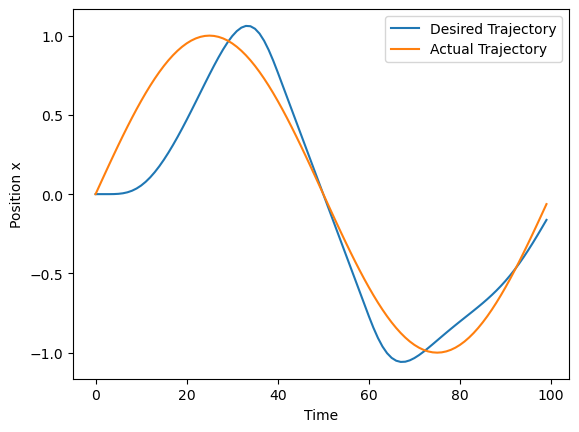

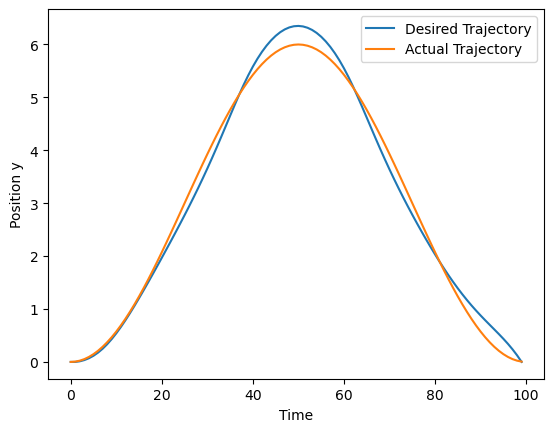

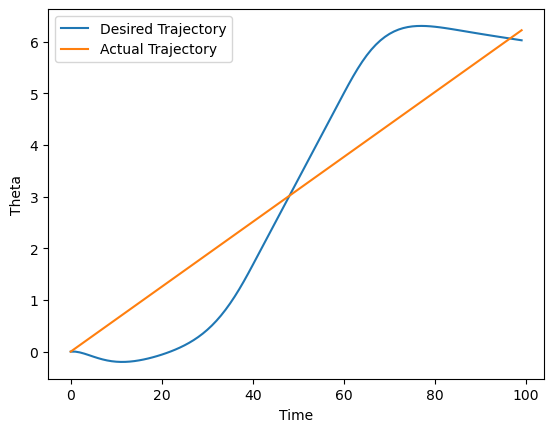

In [6]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.traj_gen(i, N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(x[0, :], label="Desired Trajectory")
plt.plot(x_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(x[2, :], label="Desired Trajectory")
plt.plot(y_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(x[4, :], label="Desired Trajectory")
plt.plot(theta_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()





In [7]:
horizon_length = 300

# Simulate the quadrotor's trajectory
x_init = np.array([0, 0, 0, 0, 0, 0])
t, state, u = quadrotor.simulate(
    x_init,  # Initial state
    opt.controller,  # Controller function
    horizon_length,  # Simulation length
    disturbance=True  # Enable disturbances
)

# Animate the quadrotor's trajectory
quadrotor.animate_robot(state, u)

For k = 0
    x_init  = [ 2.80119513e-24 -6.50581512e-17 -1.19066248e-21  3.96271962e-11
  1.19061358e-17  8.06562568e-17]
    u = [0.46730036 7.75252142]
    Next State = [-2.60232325e-18 -7.28874564e-17  1.58508785e-12  2.65185743e-01
  1.51323861e-17 -4.37113264e-01]
For k = 1
    x_init  = [ 2.87658722e-19 -7.40503962e-01  4.82699673e-21  9.87198999e-01
 -2.55131020e-17 -1.09866202e+00]
    u = [1.22239576e-10 4.06335228e+00]
    Next State = [-0.02962016 -0.74050396  0.03948796  0.91986718 -0.04394648 -1.34246316]
For k = 2
    x_init  = [-0.02962016 -0.74050395  0.03948796  0.91986717 -0.04394648 -1.34246314]
    u = [2.01855255 3.51699172]
    Next State = [-0.05924032 -0.7210488   0.07628265  0.96988315 -0.09764501 -1.43236949]
For k = 3
    x_init  = [-0.05924032 -0.7210488   0.07628265  0.96988315 -0.09764501 -1.43236949]
    u = [3.93406513 3.21591287]
    Next State = [-0.08808227 -0.66528474  0.11507797  1.14675668 -0.15493979 -1.38928036]
For k = 4
    x_init  = [-0.08808

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA2ShtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EVRliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8
dV/vzdYNgHyNMQMYbCtp3Te5K1aVTFFV6sDhAOBm+U1wqSLvWAJb5Z17JHtr26nfayIkr84mLavN
uYtEd070a0a9ZszjGfAtQrvStJG9rMUpINbKBScLEf57FnPxLwtx9C/uXlmqbzrcbSpeqxlSGl9B
SFqXOymiUUXJDEAiFn5eoaJtHM76WDdRTxhaPitkh9CQGq91Pwe5RR/6jlcnbr7csqIESuhyftW3
iRyNKEtESY1euYcpcxKSDXfCQtNT2NXDqBcJctYky35tVgovwxSWB9HCZVH5N37v/voXSu8KEpez
soE9qt1TswCfHduuEi3fqkotD8eFmv/l+ScnPy60UANHvXLaqhKYONaGwF+j/SwNh+qnYDwEUj+c
LTvaIBvMZLYsdWV36afnD3kcya8UIexqXHIatXGjc1xjJr+owZit5DVUjiysbo7pkRz+7WafuwKx
PhmJZQ/IZTkk8PuMGmw5rWS3oBoqAZsRUKZA6D4HT2aawAFYjIwJXsPUuJ6Tmyj4UFg4ZBUgI/GC
lKI312NnP2n54v2QFKr2QWzHmrfEqqNG9W6MXsOHzhXk5tzin9/OxailSI81QqWkVxhMlBoO5G/A
ZvBmfiLbPUsXBmnlz+/UwWvmB4Of17ToyZ6nGXsu0sRs5lbvtad+J7KysPw9/0eaZn4N5guZUrhM
DeGSvJnTFbW+C3lDS90HGn41tsXvCBSn3ywtJkG8wILRxT38KSVRvyIxYr++Ipbx6Jrt5dxXoczW
ZYfT7j/5Lo1SCTr3b0ena1q9a6w52DTOES3DDRUVrIhhbn7LLwbDPUTVsKMjxfiW5MbUjPMBdIFO
gjiRkq8q4E/+pjHhBKc4fES7sKL3tR1BlmeP94J2olS8uCN/Y3HVTGMTPwyySqcR1++9aEKfECZz
tF4Vgh0WvHG/QYyc8OgoIPZGQRqIMOsVEZ+Zr4QHKu6lqWWyMuFksTic0HyVOfOc4wyXze8paS0Z
HuTIVIb5Z5zfltAWU84wDHUnAIXMRAD7RT9A+I/9jYxeB8G1PD+oKWutbe1y38zXH/MhWX2VIVhf
7V4soR2AC/GWXSyc0ZlLag+HLjoVBS2BxSR8av9VGVihpsliKCFXPcXdV6grJP7jVQcyXIwdxLRu
kXpRfBvYlU+TSU7qgpGm5cYi2FvwllgWJyy0gcLED8YCcAa8U0PxZn4fHzowDrb/H4aMMNnILEqQ
TsHP01FlbX21x0ZOekyhV77qw9vb2on6CSzUQ82d2srtz16LcBqi+Pt79YMOjH/Y2idZnfJBfjau
KGO+B6rUoLhbMH605Rqq3ozJJRg7Xl72Cfxjz0yczeKvybB4IdwGa7JAUARq5nBWM0/6OQABm7sN
YTRv8MNC4dpsJ58xLxR7TyPT/PQpx2XEZw8PHzMzzHXkxtWK9ZyZ4LcY4UWXj3pgvBogMgv+3TeZ
Ir+EHh5UwBnMUYDj8DDIyUEZQbDvfazjMt1JYAABhPxo7JLr01G2PWfYVMywh/6Y0/T8AALG1JyV
QH8XIQbENqI4gfSaPwB/MwlnoY1zyqgPQU//NceEEV+HW9uk8L8dKCCcZYzSVrGGsidh2EG9fExm
3qS7YuHOhlREjq3aNZ5EPZ4xoPyGNkT+88xQr62GpwGfsKQ14pRp3v2Lo2CT9gQaJi6t0dTeRePK
BA3AeTKM/pzl3WmaJYqr8u7iqNLdW6SGbvwbL/xihBfrXvRFvQ8R+JKRFyMjz3Y24PDxTMNGl69Q
GYAUSZW4X5EJO6o6v9tP/bkIHAHqaKNaFU8BvKNjVc66bfrk6C4gK9StYrgKay0tIXF6cGnm0znk
YwDXYNFXlMH/6xvsIhXNbbGsuEKAuRohU6myjUzw/YrSAG6PJHeSpzucvJwTLQQu3T8ZYG8DXBQB
B0rmaayXGI0ZgM7Yly1fN6tN7AACZ02+GH1hOpsi60In+lXUefDTkoTrxJLbFENyfALXC0ulRz11
5NDnAXZaxsfqBW33TaHSCx0lJ1Dyocgd/8+nfApef0qzkxdCKQnEUKlZu4FT3V97eUfZmjDK6iAY
ESNNNsCh48FHSPSE6kX/j6Ly8fTPLE5jN+r/3pEgjzVZKf//87crtP+ed9jJyNAXnQ5LIiBaiX6I
NYXRAzYVS4ep2KktiGhywABt62/dT/9tZ1v1mzqDd/bsCQBWhYkAAAMADIVYPMKXN+reb/DyliJ8
eEscl9FCpIRv1VDD3noppI8gru3a8ckcQDx6c64gNSdE4+BRrw667GqAzY0rRlwjLB3W8Lzt0O6w
u5xCKpFzK9QycG8I3mfC5Vt4vB4v1RQUstlC5cnOWE48Vo/+CX7eY7s9vRX3KOhD3P/1Q8TbWFuP
J2YXObKz/aw1T3a75qvEOcpBa62FE0ccx7N9XblIBE4eIgpB+JkmPdgjzVMwYJj8K/y3l7Lwxm2e
Sj6dfnCYKeIumr4N5yQFE

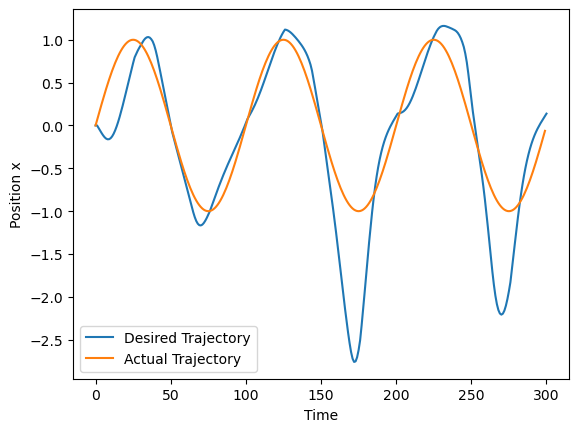

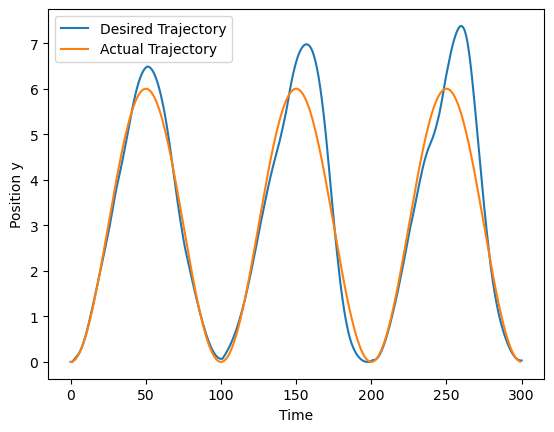

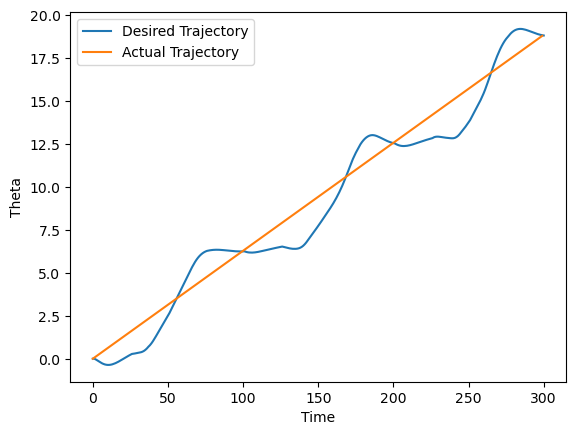

In [8]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(horizon_length)
y_traj = np.zeros(horizon_length)
theta_traj = np.zeros(horizon_length)

for i in range(horizon_length):
    des_x, des_y, des_theta = traj.traj_gen(i, N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(state[0, :], label="Desired Trajectory")
plt.plot(x_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(state[2, :], label="Desired Trajectory")
plt.plot(y_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(state[4, :], label="Desired Trajectory")
plt.plot(theta_traj, label="Actual Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()



